In [1]:
import json
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import networkx as nx
import numpy as np
from math import dist
import copy
import matplotlib.pyplot as plt
##### model
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN


import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils.convert import from_networkx


%matplotlib inline



/Users/yanircohen/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# crate a list to add dataframes to
awsc_list = list()

# list of files
files_list = ['../Datasets/attack3.json']

# Load event names
category_file = open("../Utils/event_category.json")
event_categories = json.load(category_file)
category_file.close()

encoder = OneHotEncoder(handle_unknown='ignore')
label_encoder = LabelEncoder()

In [3]:
for file in files_list:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.loads(f.read())
        
        # Append the dataframes
        awsc_list.append(pd.DataFrame.from_records(data['Records']))

In [4]:
awsc = pd.concat(awsc_list).reset_index(drop=True)

In [5]:
awsc[(awsc['eventSource']=='cognito-idp.amazonaws.com')]

,eventVersion,userIdentity,eventTime,eventSource,eventName,awsRegion,sourceIPAddress,userAgent,requestParameters,responseElements,...,eventCategory,tlsDetails,errorCode,errorMessage,additionalEventData,apiVersion,vpcEndpointId,resources,sessionCredentialFromConsole,sharedEventID


In [6]:
users = pd.json_normalize(awsc['userIdentity']).merge(awsc[['eventTime','eventName','eventSource','awsRegion','errorCode']], left_index=True,right_index=True)

In [7]:
users['userName'] = users['userName'].fillna(users['arn']).fillna(users['invokedBy']) \
.fillna(users['invokedBy']).fillna(users['principalId']).fillna('accountId')

In [8]:
users = users[['eventTime','type','userName','eventName','eventSource','awsRegion','errorCode']]
users = users.rename(columns = {'eventTime':'timestamp','userName':'Identifier','eventSource':'TargetService','errorCode':'Error'})


In [9]:
users.head()


,timestamp,type,Identifier,eventName,TargetService,awsRegion,Error
0,2023-04-23T10:45:02Z,IAMUser,sec-check,ListFunctions20150331,lambda.amazonaws.com,us-east-1,NaN
1,2023-04-23T10:44:40Z,IAMUser,sec-check,GetCredentialReport,iam.amazonaws.com,us-east-1,CredentialReportNotPresentException
2,2023-04-23T10:44:39Z,IAMUser,sec-check,GetCredentialReport,iam.amazonaws.com,us-east-1,CredentialReportNotPresentException
3,2023-04-23T10:44:30Z,IAMUser,sec-check,GetCredentialReport,iam.amazonaws.com,us-east-1,CredentialReportNotPresentException
4,2023-04-23T10:44:26Z,IAMUser,sec-check,GetAccountPasswordPolicy,iam.amazonaws.com,us-east-1,NoSuchEntityException


In [10]:
users['timestamp'] = pd.to_datetime(users['timestamp']).map(pd.Timestamp.timestamp).map(int)
users = users.sort_values('timestamp',ascending=True,ignore_index=True)

In [11]:
users['Identifier'] = users['Identifier'].apply(lambda x : x if (len(x.split(":"))!=2) else x.split(":")[1])
users.nunique()

timestamp        59350
type                 5
Identifier          30
eventName          564
TargetService       79
awsRegion           15
Error               71
dtype: int64

In [12]:
users['identity-target'] = "source-"+users['Identifier'] + "|" + "target-"+ users['TargetService']

In [13]:
users.head()

,timestamp,type,Identifier,eventName,TargetService,awsRegion,Error,identity-target
0,1486929426,Root,arn:aws:iam::123456789:root,ListBuckets,s3.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::123456789:root|target-s3.a...
1,1486929550,Root,arn:aws:iam::123456789:root,ListAccountAliases,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::123456789:root|target-iam....
2,1486929550,Root,arn:aws:iam::123456789:root,GetAccountSummary,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::123456789:root|target-iam....
3,1486929550,Root,arn:aws:iam::123456789:root,ListMFADevices,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::123456789:root|target-iam....
4,1486929550,Root,arn:aws:iam::123456789:root,ListAccountAliases,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::123456789:root|target-iam....


In [14]:
users['Identifier'] = users['Identifier'].apply(lambda x : f"source-{x}")
users['TargetService'] = users['TargetService'].apply(lambda x : f"target-{x}")

In [15]:
users = users[ (users['Identifier'] != "source-arn:aws:iam::123456789:root")]
users = users[ (users['Identifier'] != "source-cloud_user")]
# users = users[ (users['Identifier'] != "source-sec-check")]
# users = users[ (users['Identifier'] != "source-arn:aws:sts::811596193553:assumed-role/backend_serverֿ/i-0e113c6c02d37490f")]
# users = users[ (users['Identifier'] != "source-HIDDEN_DUE_TO_SECURITY_REASONS")]
# users = users[ (users['Identifier'] != "source-arn:aws:sts::811596193553:assumed-role/Level6/Level6")]
# users = users[ (users['Identifier'] != "source-backup")]
# users = users[ (users['Identifier'] != "source-Level6")]
# users = users[ ( users['Identifier'].str.contains("amazonaws.com") == False)]
users = users[ ( users['Identifier'].str.contains("i-0") == False)]

In [16]:
def get_time_df(start,end,minutes,df,col='timestamp'):
    minutes = minutes * 60
    df_list = []
    start_time = start
    df_len = 0
    while start < end:
        cur_df = df[(df[col] >= start_time) & (df[col] < start+minutes)]
        if len(cur_df) != df_len:
            df_list.append(df[(df[col] >= start_time) & (df[col] < start+minutes)])
            df_len = len(cur_df)
        start+=minutes
    return df_list

In [17]:
df_list = get_time_df(users['timestamp'].iloc[0],users['timestamp'].iloc[-1],60*24*30,users)

In [18]:
len(df_list)

17

# Create the graph

In [19]:
nodes = ['Identifier','TargetService']
edges = ['identity-target']


In [20]:
def add_nodes(g,df,col,x,jump=10):
    y = 10
    unique_nodes = df[col].unique()
    for i in unique_nodes:
        if i!= None:
            g.add_node(f'{i}',pos=(x,y))
            y+=jump
#     for i in range(len(unique_nodes)-1):
#         g.add_edge(unique_nodes[i],unique_nodes[i+1])

def add_edges(g,df,col):
    edges = df[col].value_counts()
    for node,value in edges.items():
        start_node,end_node = node.split('|')
        if "None" not in start_node and "None" not in end_node:
            g.add_edge(start_node, end_node, weight=1)

In [21]:
def generate_graph(G,df_nodes,df_edges):  
    x = 10
    nodes_li = []
    for node in nodes:
        add_nodes(G,df_nodes,node,x,100)
        x+=1
        nodes_li.append(df_nodes[node].unique())
    for i in range(len(nodes_li)-1):
        for node1 in nodes_li[i]:
            for node2 in nodes_li[i+1]:
                G.add_edge(node1,node2,weight=0)
    for edge in edges:
        add_edges(G,df_edges,edge)

In [22]:
G = nx.Graph()

In [23]:
generate_graph(G,users,users)

In [24]:
def generate_graphs(df,df_list):
    li = []
    for data in df_list:
        G = nx.Graph()
        generate_graph(G,df,data)
        li.append(G)
    return li

In [25]:
graphs = generate_graphs(users,df_list)

In [26]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 10
# pos=nx.get_node_attributes(G,'pos')
# # pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
# d = dict(G.degree)
# nx.draw(G, pos, node_color='lightblue', 
#         with_labels=True, 
#         nodelist=d, 
#         node_size=[d[k]*300 for k in d])
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=5)
# import matplotlib.pyplot as plt
# plt.savefig(f'plotgraph.png', dpi=300, bbox_inches='tight')


# pos=nx.get_node_attributes(G,'pos')
# nx.draw(G,pos)
# plt.show()

In [27]:
df = nx.to_pandas_adjacency(G, dtype=float)

In [28]:
df.head()

,source-backup,source-arn:aws:sts::123456789:assumed-role/level5/level5,source-Level5,source-lambda.amazonaws.com,source-ec2.amazonaws.com,source-Level6,source-arn:aws:sts::123456789:assumed-role/lambda_basic_execution/Level6,source-piper,source-HIDDEN_DUE_TO_SECURITY_REASONS,source-cloudsploit-api,...,target-docdb-elastic.amazonaws.com,target-dax.amazonaws.com,target-backup.amazonaws.com,target-backup-gateway.amazonaws.com,target-athena.amazonaws.com,target-pricelist.amazonaws.com,target-glue.amazonaws.com,target-datazone.amazonaws.com,target-states.amazonaws.com,target-account.amazonaws.com
source-backup,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-arn:aws:sts::123456789:assumed-role/level5/level5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-Level5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-lambda.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-ec2.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=74)
X = embedding.fit_transform(df)

In [30]:
X

array([[ 4.44602973e-05,  5.76405157e-02, -4.38109106e-04, ...,
        -8.78726180e-03,  3.96538144e-05,  3.03077295e-04],
       [-7.66160321e-06,  5.47133378e-02, -6.85529908e-05, ...,
        -4.25175654e-02,  3.55324137e-04, -4.89656437e-03],
       [ 4.65843363e-05,  5.67517064e-02, -3.09218341e-04, ...,
        -8.37841655e-04, -2.81676751e-04, -1.86801267e-02],
       ...,
       [ 4.49605271e-02, -2.00909550e-02,  2.98023036e-06, ...,
        -1.83419485e-03,  1.29871257e-04,  1.23344714e-02],
       [ 4.49605271e-02, -2.00909550e-02,  2.98023036e-06, ...,
        -1.83419485e-03,  1.29871257e-04,  1.23344714e-02],
       [ 9.16940853e-03,  4.02742309e-02, -1.17881679e-04, ...,
        -1.11250856e-02,  1.04794583e-03,  1.28720980e-01]])

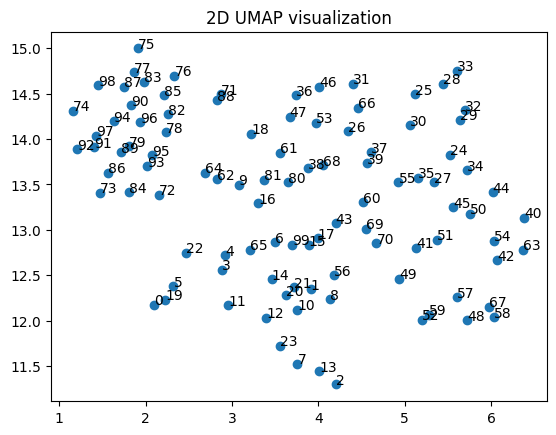

In [31]:
import umap
# Create a UMAP object with 2 components (i.e., 2D)
umap_2d = umap.UMAP(n_components=2)

# Fit and transform the dataset using UMAP
X_umap_2d = umap_2d.fit_transform(X)

# Visualize the results
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1])
for i,other in enumerate(X_umap_2d):
    x,y = other
    plt.text(x,y,i)
plt.title('2D UMAP visualization')
plt.show()

In [32]:
df_from_graphs = []
for graph in graphs:
    df_from_graphs.append(nx.to_pandas_adjacency(graph, dtype=float))

In [33]:
distance_df = df.replace(1,0).copy(deep=True)

In [34]:
distance_df

,source-backup,source-arn:aws:sts::123456789:assumed-role/level5/level5,source-Level5,source-lambda.amazonaws.com,source-ec2.amazonaws.com,source-Level6,source-arn:aws:sts::123456789:assumed-role/lambda_basic_execution/Level6,source-piper,source-HIDDEN_DUE_TO_SECURITY_REASONS,source-cloudsploit-api,...,target-docdb-elastic.amazonaws.com,target-dax.amazonaws.com,target-backup.amazonaws.com,target-backup-gateway.amazonaws.com,target-athena.amazonaws.com,target-pricelist.amazonaws.com,target-glue.amazonaws.com,target-datazone.amazonaws.com,target-states.amazonaws.com,target-account.amazonaws.com
source-backup,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-arn:aws:sts::123456789:assumed-role/level5/level5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-Level5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-lambda.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
source-ec2.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
target-pricelist.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target-glue.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target-datazone.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target-states.amazonaws.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
from sklearn.neighbors import NearestNeighbors
a = 1
for df_graph in df_from_graphs:
#     a+=1
    target_cols = [col for col in df_graph.columns if 'target' in col]
    for col in target_cols:
        index_di = {}
        index_to_pd_index = {}
        nodes = df_graph[col].loc[df_graph[col]==1]
        for i,other in enumerate(nodes.items()):
            ind,_=other
            pd_index = df_graph.index.get_loc(ind)
            index_di[pd_index] = ind
            index_to_pd_index[i] = ind
        if len(index_di) > 1:
            x = X[list(index_di.keys())]
            nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(x)
            distances, indices = nbrs.kneighbors(x)
            for i,other in enumerate(index_di.items()):
                key,value = other
                nearest_neighbor = indices[i][1]
                nearest_neighbor_ind = index_to_pd_index[nearest_neighbor]
                if distance_df.loc[value,nearest_neighbor_ind] ==  0:
                    distance_df.loc[value,nearest_neighbor_ind] = distances[i][1]*a

In [36]:
cols = [c for c in distance_df.columns if 'target' not in c]

distance_df = distance_df[cols].drop(distance_df.columns.difference(cols))

In [37]:
result = nx.from_pandas_adjacency(distance_df)

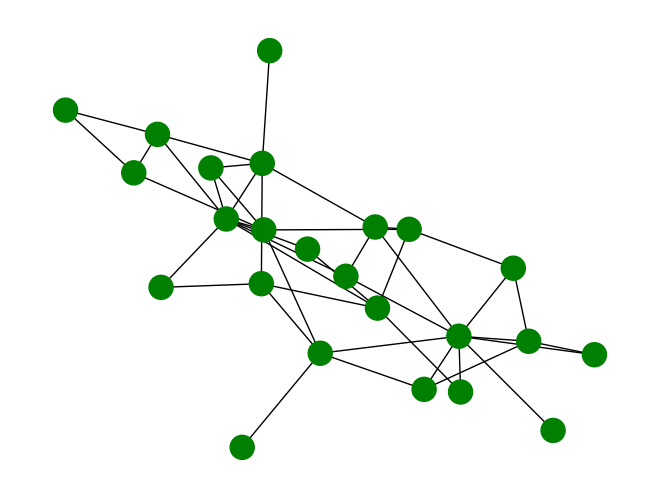

In [38]:
color_map = ['red' if node == 'source-cloud_user' else 'green' for node in result]        
# pos=nx.spring_layout(result) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw(result,node_color=color_map)
# labels = nx.get_edge_attributes(result,'weight')
# nx.draw_networkx_edge_labels(result,pos=pos)
plt.savefig("res.png")

In [39]:
distance_df

,source-backup,source-arn:aws:sts::123456789:assumed-role/level5/level5,source-Level5,source-lambda.amazonaws.com,source-ec2.amazonaws.com,source-Level6,source-arn:aws:sts::123456789:assumed-role/lambda_basic_execution/Level6,source-piper,source-HIDDEN_DUE_TO_SECURITY_REASONS,source-cloudsploit-api,...,source-config.amazonaws.com,source-arn:aws:sts::123456789:assumed-role/config-role-us-west-2/AWSConfig-BucketConfigCheck,source-arn:aws:sts::123456789:assumed-role/config-role-us-west-2/AWSConfig-Describe,source-AIDA8M82W7I80M2DIZCF5,source-arn:aws:sts::123456789:assumed-role/SummitRouteAudit/audit,source-flaws,source-arn:aws:sts::123456789:assumed-role/test-role-e7op7eos/test,source-arn:aws:sts::123456789:assumed-role/test-role-b0l6gbt2/test,source-vpc_peering,source-test
source-backup,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.656514e-15,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
source-arn:aws:sts::123456789:assumed-role/level5/level5,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.508106e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.336569,0.0,0.000000
source-Level5,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.867964e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
source-lambda.amazonaws.com,0.000000e+00,0.000000,0.000000,0.000000,0.359211,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.288940,0.000000,0.000000,0.000000,0.0,0.000000
source-ec2.amazonaws.com,0.000000e+00,0.000000,0.000000,0.359211,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.288940,0.000000,0.000000,0.000000,0.0,0.000000
source-Level6,2.656514e-15,0.350811,0.386796,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.393014,0.0,0.000000,0.372324,0.000000,0.000000,0.0,0.454255
source-arn:aws:sts::123456789:assumed-role/lambda_basic_execution/Level6,0.000000e+00,0.366204,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.352430,0.0,0.000000
source-piper,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.335406,0.000000,...,0.375485,0.000000,0.000000,0.0,0.321399,0.000000,0.000000,0.000000,0.0,0.397595
source-HIDDEN_DUE_TO_SECURITY_REASONS,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.335406,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
source-cloudsploit-api,0.000000e+00,0.000000,0.000000,0.361956,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.280333,0.000000,0.000000,0.000000,0.0,0.000000


In [40]:
ans = distance_df.T.max().reset_index().rename(columns={0:'Anomaly Score'})

In [41]:
ans.sort_values('index',inplace = True,ignore_index=True)

In [42]:
# a, b = 0, 2.5
# x, y = ans['Anomaly Score'].min(), ans['Anomaly Score'].max()
# ans['Anomaly Score'] = (ans['Anomaly Score'] - x) / (y - x) * (b - a) + a

In [43]:
ans['Node'] = ans.index

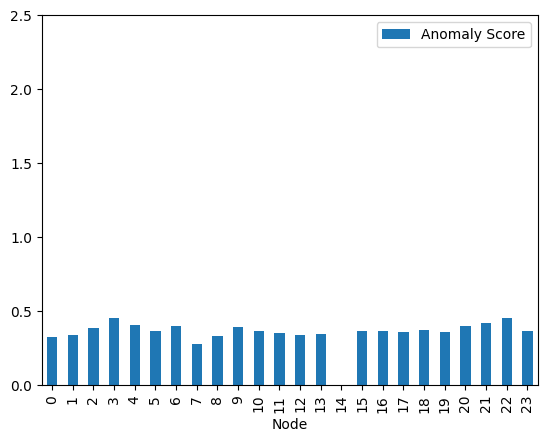

In [44]:
ax = ans.plot(kind = "bar",x='Node',
                      y='Anomaly Score',ylim=(0,2.5))

In [45]:
for i in enumerate(ans['index']):
    print(i)

(0, 'source-AIDA8M82W7I80M2DIZCF5')
(1, 'source-HIDDEN_DUE_TO_SECURITY_REASONS')
(2, 'source-Level5')
(3, 'source-Level6')
(4, 'source-arn:aws:sts::123456789:assumed-role/Cloudsploit/cloudsploit_scan')
(5, 'source-arn:aws:sts::123456789:assumed-role/SecurityMonkey/cloudaux')
(6, 'source-arn:aws:sts::123456789:assumed-role/SecurityMonkey/secmonkey')
(7, 'source-arn:aws:sts::123456789:assumed-role/SummitRouteAudit/audit')
(8, 'source-arn:aws:sts::123456789:assumed-role/config-role-us-west-2/AWSConfig-BucketConfigCheck')
(9, 'source-arn:aws:sts::123456789:assumed-role/config-role-us-west-2/AWSConfig-Describe')
(10, 'source-arn:aws:sts::123456789:assumed-role/lambda_basic_execution/Level6')
(11, 'source-arn:aws:sts::123456789:assumed-role/level5/level5')
(12, 'source-arn:aws:sts::123456789:assumed-role/test-role-b0l6gbt2/test')
(13, 'source-arn:aws:sts::123456789:assumed-role/test-role-e7op7eos/test')
(14, 'source-backup')
(15, 'source-cloudsploit-api')
(16, 'source-config.amazonaws.com')


In [46]:
ans['Anomaly Score'].std()

0.08530463782360269

In [47]:
ans['Anomaly Score'].mean()

0.3553397097365359

In [48]:
ans[ans['Anomaly Score'] > ans['Anomaly Score'].mean() + 2*ans['Anomaly Score'].std()] 

,index,Anomaly Score,Node


In [49]:
ans['Anomaly Score'].mean()

0.3553397097365359

In [50]:
ans['Anomaly Score'].mean() + 2*ans['Anomaly Score'].std()

0.5259489853837412

In [51]:
ans['Anomaly Score'].mean() + 1*ans['Anomaly Score'].std()

0.4406443475601386

In [52]:
ans['Anomaly Score'].std()*ans['Anomaly Score'].std()

0.007276881234216027